inspired by: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/ViTMAE/ViT_MAE_visualization_demo.ipynb

# Visualization demo: Distillation with no Labels (DINO)

In this notebook, we are going to visualize some predictions of a Vision Transformer (ViT) pre-trained on self-distillation with no labels. The student tries to predict teacher-produced pseudolabels for local crops of an image(as shown in the figure below).

<img src="https://github.com/facebookresearch/dino/raw/main/.github/dino.gif" width="600" class="center"/>

* Paper: https://arxiv.org/abs/2104.14294
* Original repo: https://github.com/facebookresearch/dino
* Interactive demo: https://ssl-demos.metademolab.com/

## Set-up environment

In [3]:
#!pip install -q git+https://github.com/huggingface/transformers.git

## Prepare image

Here we apply some very basic image processing, namely resizing to 224x224 and normalizing the channels.

Image size: (640, 400)


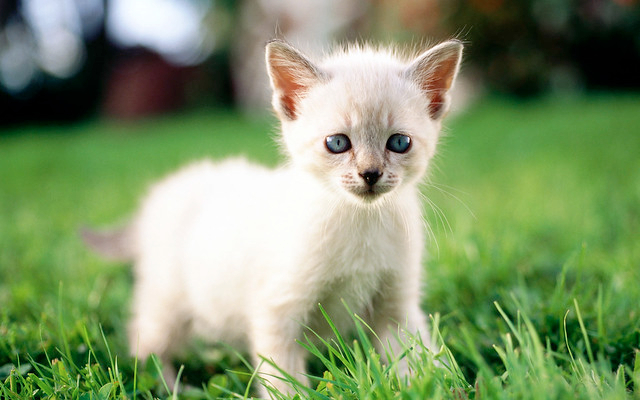

In [4]:
import requests
from PIL import Image

url = "https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg"
#image = Image.open(requests.get(url, stream=True).raw)
image = Image.open('../cil-data/training/images/satimage_2.png').convert('RGB')
image = Image.open('cat.png').convert('RGB')
print(f'Image size: {image.size}')
image

## Visualization

Next, we forward the pixel values through the model. The encoder (which is a standard Vision Transformer) will first encode the visual patches.

In [5]:
import torch
import torch.nn as nn
import numpy as np
from transformers import ViTFeatureExtractor

torch.manual_seed(2)

model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
#model = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')

# Use huggingface feature extractor for preprocessing
feature_extractor = ViTFeatureExtractor(
    do_resize = True,
    size = (224,224),
    do_normalize=True,
    image_mean = [0.485, 0.456, 0.406], # imagenet mean
    image_std = [0.229, 0.224, 0.225] # imagenet std
)

# adjust to return embeddings, source:
# https://github.com/facebookresearch/dino/blob/cb711401860da580817918b9167ed73e3eef3dcf/vision_transformer.py#L209
def forward(x):
    x = model.prepare_tokens(x)
    for blk in model.blocks:
        x = blk(x)
    x = model.norm(x)
    return x # x[:, 0] is [CLS] embedding
model.forward = forward

print(model)

/home/felix/miniconda3/envs/cil/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /home/felix/.cache/torch/hub/facebookresearch_dino_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

### Visualizing the Attention

In [6]:
# don't normalize
#feature_extractor.imagenet_mean = (0,0,0)
#feature_extractor.imagenet_std = (1,1,1)

In [7]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def denormalize(image):
    imagenet_mean = np.array(feature_extractor.image_mean)
    imagenet_std = np.array(feature_extractor.image_std)
    return image * imagenet_std + imagenet_mean

def show_image(image, title=''):
    # image is [H, W, 3] or [H, W, 1]
    plt.imshow(torch.clip(image * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def show_mask(mask, title=''):
    # image is [H, W, 3] or [H, W]
    plt.imshow(mask)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize_att(img, model):

    # prepare model
    patch_size = model.patch_embed.patch_size
    for p in model.parameters():
        p.requires_grad = False
    model.eval()


    print(f'img.shape: {img.shape}')
    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    # forward pass
    attentions = model.get_last_selfattention(img) # [n_batches, n_heads, n_emb_att_to, n_emb_att_from]
    attentions = attentions[0, :, 0, 1:] # we keep only the output patch attention for [CLS]
    nh = attentions.shape[0] # number of head

    # convert to [n_heads, n_channels, with, height]
    attentions = attentions.reshape(nh, 1, w_featmap, h_featmap)
    mask = F.interpolate(attentions, scale_factor=patch_size, mode="nearest")

    # transpose channels to back
    x = torch.einsum('nchw->nhwc', img)[0]
    mask = torch.einsum('nchw->nhwc', mask)
    
    # map to RGB colorspaces
    x = denormalize(x)
    mask = mask.repeat(1,1,1,3)

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 6]
    plt.suptitle('Last-layer attention of [CLS] token', fontsize=26)

    plt.subplot(1, nh + 1, 1)
    show_image(x, "original")

    for j in range(nh):    
        plt.subplot(1, nh + 1, j+2)
        show_image(x * mask[j] / mask[j].max(), f"head {j}")


    plt.show()

img.shape: torch.Size([1, 3, 224, 224])


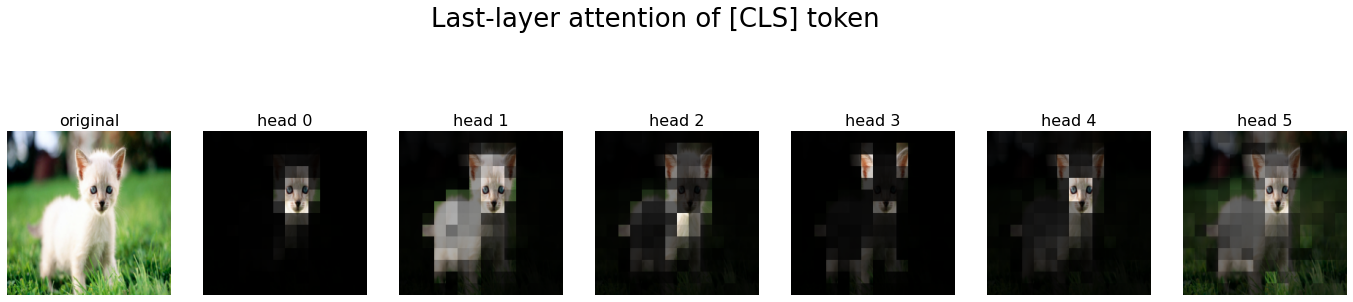

In [8]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
visualize_att(pixel_values, model)

### Visualize within-image PCA of patch embeddings



In [9]:
from sklearn.decomposition import PCA

def map_cmap(bw, cmap_name):
    cmap = plt.get_cmap(cmap_name)
    norm = plt.Normalize()
    
    # image is [H, W, 1]
    img_rgba = cmap(norm(bw[:,:,0]))
    img_rgb = img_rgba[:,:,:3]
    return torch.from_numpy(img_rgb)

def map_gray(img):
    # image is [H, W, 3]
    coeff = torch.tensor([0.21626, 0.7152, 0.0722], dtype=torch.float64)
    return img.matmul(coeff).unsqueeze(-1)



def visualize_emb(img, model):
    img = feature_extractor(image, return_tensors="pt").pixel_values

    # prepare model
    patch_size = model.patch_embed.patch_size
    for p in model.parameters():
        p.requires_grad = False
    model.eval()

    print(f'img.shape: {img.shape}')
    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    # forward pass
    output = model(img) # [n_batches, n_embeddings, n_channels]
    output = output[0, 1:, :] # keep only patch embeddings, discard [CLS] embedding

    # use first principal coponent for colorgrading
    pc = torch.from_numpy(PCA(n_components=1).fit_transform(output))

    # convert to [n_heads, n_channels, with, height]
    pc = pc.reshape(1, 1, w_featmap, h_featmap)
    cmask = F.interpolate(pc, scale_factor=patch_size, mode="nearest")

    # transpose channels to back
    x = torch.einsum('nchw->nhwc', img)[0]
    cmask = torch.einsum('nchw->nhwc', cmask)[0]

    # map to RGB colorspaces
    x = denormalize(x)
    cmask = map_cmap(cmask, 'jet')

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 6]
    plt.suptitle('Within-image PCA of patch embeddings', fontsize=26)


    plt.subplot(1,2,1)
    show_image(x, 'original')

    plt.subplot(1,2,2)
    show_image((cmask + x)/2, "principal component")


    plt.show()



img.shape: torch.Size([1, 3, 224, 224])


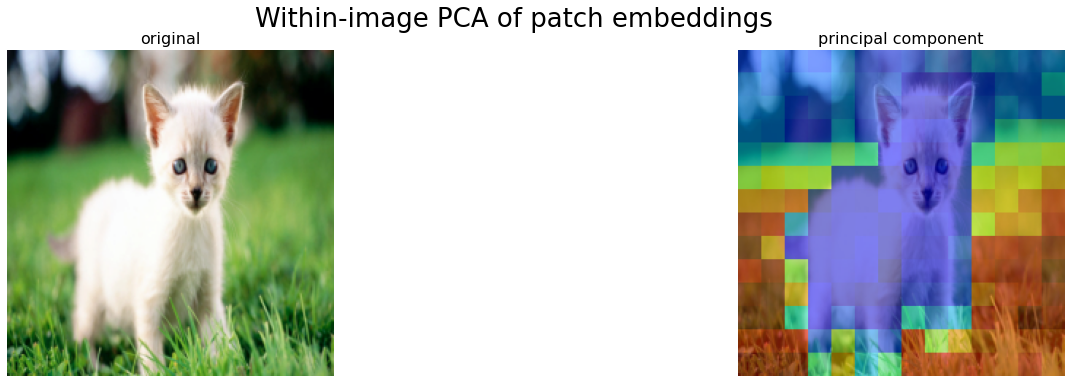

In [10]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
visualize_emb(pixel_values, model)

## Change Input Image Size to Original Image size

The model works out of the box with differently sized images. No code changes required here. 

img.shape: torch.Size([1, 3, 400, 640])


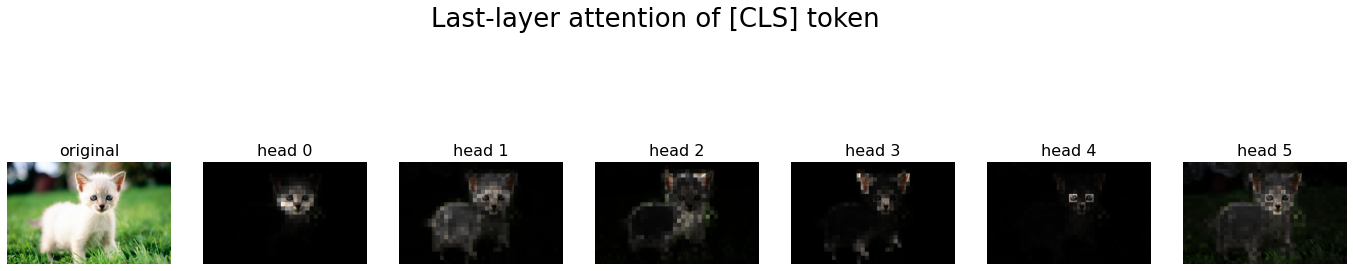

img.shape: torch.Size([1, 3, 400, 640])


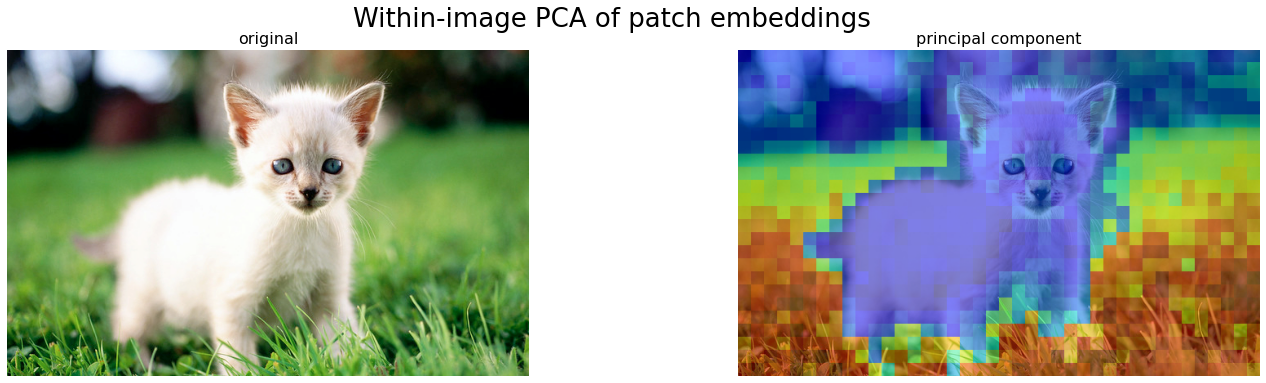

In [11]:
feature_extractor.do_resize = False
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
visualize_att(pixel_values, model)
visualize_emb(pixel_values, model)

## After pre-training

Fine-tuning and linear probing can be done directly with the model. Instead we use the vit_embeddings module to generate the patchwise embeddings for every image and analyize them using more traditional methods.

In [12]:
%load_ext autoreload
%autoreload 2
from vit_embeddings import *

df = convert_dataset('../cil-data', 'training', 'satimage', 'dino_vits16', image_size=400)
print(f'df.shape = {df.shape}')
df.head()

Using cache found in /home/felix/.cache/torch/hub/facebookresearch_dino_main


Compute embeddings...


100%|██████████| 144/144 [01:29<00:00,  1.61it/s]


Compute ratios...


100%|██████████| 144/144 [00:00<00:00, 317.82it/s]

df.shape = (90000, 386)


,img,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x375,x376,x377,x378,x379,x380,x381,x382,x383,y
0,0,-5.698750,-1.829384,1.767499,4.273895,-4.303300,-7.077049,-1.948868,0.640461,1.875580,...,0.569725,-2.037452,-0.789185,-0.826064,7.684974,1.960038,2.108747,-2.043561,0.149951,0.0
1,0,-5.104403,-0.504180,0.364873,3.683481,-0.511393,0.489978,-1.011689,2.196930,-0.418081,...,-1.740351,-1.869399,3.885025,4.391893,5.232518,3.441099,1.598469,0.641175,-4.333550,0.0
2,0,-3.132308,-1.031866,-0.686451,0.486410,-2.664494,-4.737079,0.815574,-0.420117,0.931598,...,-0.931269,0.865918,1.534637,4.993982,6.152890,-0.541144,13.795967,1.026543,0.978592,0.0
3,0,-0.869933,4.365164,-0.398804,0.184639,1.981062,-3.722497,4.356835,-0.064104,-1.095709,...,-2.320275,-3.836901,1.322059,5.096312,4.994920,3.125061,14.144491,3.629574,2.414497,0.0
4,0,4.774055,-3.675842,-2.172144,0.754773,3.857156,-5.831191,8.997106,-1.503242,9.865817,...,-2.189194,-2.805013,-8.071073,0.924149,0.517785,1.818485,5.168487,-3.610654,-3.164084,0.0


In [13]:
# extract embeddings and labels
lbls = df['y']
embs = df.drop(['y', 'img'], axis='columns')

#### Labels: road-ratio per patch

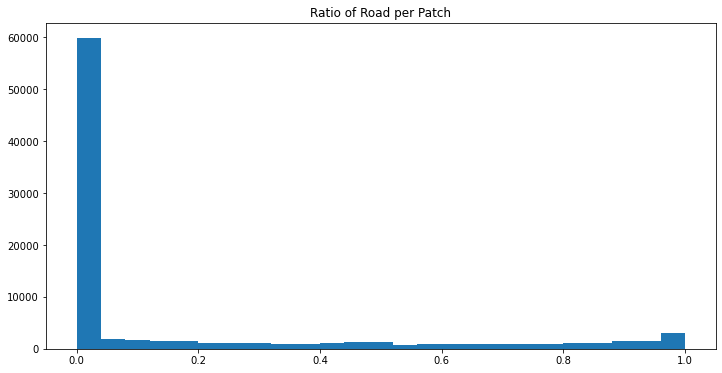

In [23]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
from sklearn.decomposition import PCA

plt.hist(lbls, bins = 25)
plt.title('Ratio of Road per Patch')
plt.show()


#### Features: Patchwise ViT embeddings

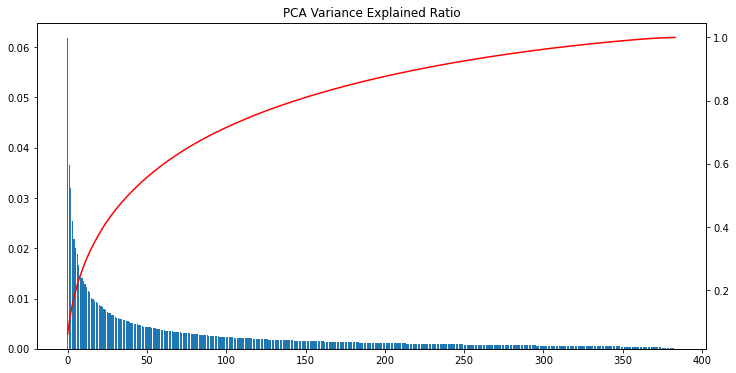

In [31]:
pca = PCA().fit(embs)
x_pca = pca.transform(embs)

indices = range(pca.n_components_)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 

ax1.bar(indices, pca.explained_variance_ratio_)
ax2.plot(indices, np.cumsum(pca.explained_variance_ratio_), c='r')
plt.title('PCA Variance Explained Ratio')
plt.show()

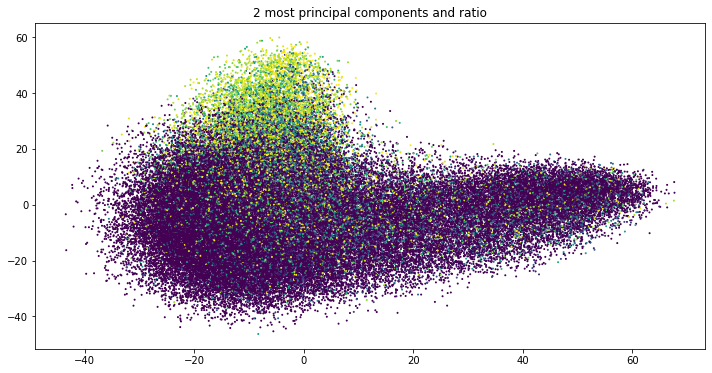

In [32]:
plt.scatter(x_pca[:,0], x_pca[:,1], c=lbls, s=1)
plt.title('2 most principal components and ratio')
plt.show()

### Logistic Regression on binary labels

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
X = scaler.fit_transform(embs)
y = pd.Series(lbls > 0.25)

folds = StratifiedKFold(n_splits=5)
for i, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    X_train, X_val = X[train_idx, :], X[val_idx, :]
    y_train, y_val = y[train_idx], y[val_idx]

    clf = LogReg(class_weight='balanced', max_iter=1e5)
    clf.fit(X_train, y_train)

    acc_train = accuracy_score(y_train, clf.predict(X_train))
    acc_val = accuracy_score(y_val, clf.predict(X_val))
    print(f'Split {i}: train={acc_train:.3f}, val={acc_val:.3f}')

Split 0: train=0.797, val=0.801
Split 1: train=0.799, val=0.784
Split 2: train=0.800, val=0.783
Split 3: train=0.798, val=0.782
Split 4: train=0.799, val=0.783


#### Use softlabels: linear regression on logits

This is a very bad workaround which should be much easier to implement in pytorch with a cross-entropy loss between the prediction and the soft labels. Unfortunately this is not available in sklearn and I just wanted to quickly try it. 

y.shape: (33753,)
X.shape: (33753, 384)


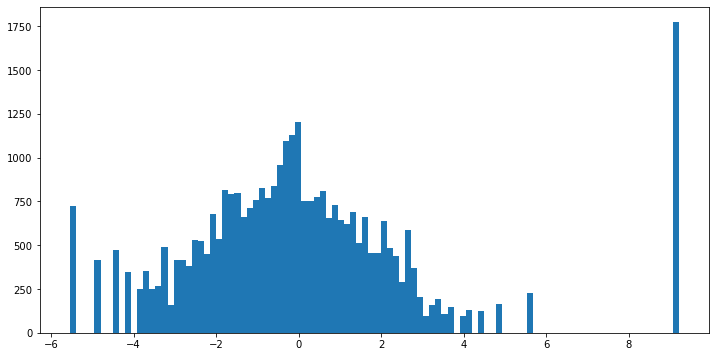

In [35]:
from scipy.special import logit, expit

eps = 1e-4
X = scaler.fit_transform(embs[lbls>0])
y = np.array(lbls[lbls>0].clip(eps, 1-eps).apply(logit))
plt.hist(y, bins = 100)

print(f'y.shape: {y.shape}')
print(f'X.shape: {X.shape}')

In [36]:
from sklearn.linear_model import LinearRegression as LinReg

def log_accuracy(y_true, y_pred, thresh=0.25):
    y_true = expit(y_true) > thresh
    y_pred = expit(y_pred) > thresh
    return accuracy_score(y_true, y_pred)

folds = KFold(n_splits=5)
for i, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    X_train, X_val = X[train_idx, :], X[val_idx, :]
    y_train, y_val = y[train_idx], y[val_idx]

    clf = LinReg() # minimizes MSE in logit space
    clf.fit(X_train, y_train)

    acc_train = log_accuracy(y_train, clf.predict(X_train))
    acc_val = log_accuracy(y_val, clf.predict(X_val))
    print(f'Split {i}: train={acc_train:.3f}, val={acc_val:.3f}')

Split 0: train=0.721, val=0.719
Split 1: train=0.721, val=0.723
Split 2: train=0.725, val=0.707
Split 3: train=0.721, val=0.705
Split 4: train=0.725, val=0.706
